In [1]:
import Euler.Periodic_1D as elr

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib import animation
from IPython.display import Video

## Solving equation

Now that we have successfully implemented both 1D advection and 1D diffusion equations, it is time to move to 2D... but before that, for the sake of completeness, we present here an equation which solves for both these processes simultaneously:

$$ \frac{\partial \phi}{\partial t} + a \frac{\partial \phi}{\partial x} = \kappa \frac{\partial^2 \phi}{\partial x^2}, $$
where $\kappa > 0$, $a$ is the advection speed and $\phi(x,t)$ is the tracer concentration.

For this equation, the analytical solution is given by:
$$ \phi(x,t) =  e^{-\lambda^2 \kappa t} A sin( \lambda (x - at)), $$

where $\lambda = \frac{2 \pi n x}{L_x}$ and $t$ is the elapsed time (in seconds).

Since we have to impose periodic boundary conditions, we take the full sine curve, and assume $A = 1$, and $n = 1$. 

We have a module named Euler, which contains equations for 1D and 2D advection and diffusion for different types of differencing schemes. Like before, we implement periodic boundary conditions at our end points.

In [3]:
#Length of domain
Lx = 100

#Number of points in the domain
nx = 40

#Width of each cell
dx = Lx/nx

g = 9.81
rho0 = 1025

#An array of all points
x = np.linspace(0,Lx,nx+1,dtype = float)
x = x[0:-1]

In [4]:
#Wavelength
lmda = (2*np.pi)/Lx

#Initialising variables
phi_old = (np.sin(lmda*x))
phi_old_t0 = (np.sin(lmda*x))
phi_new = np.zeros(nx)

#Time parameters
t_start = 0
t_end = 40.01
dt = 0.5

#Set switch - (i) FD = 1, (ii) BD = -1, (iii) CD = 0, and (iv) Always first order stable = 2
#By default, switch is set to 0.
switch_diff_scheme = 0    #Switch for diffusion
switch_adv_scheme = 0    #Switch for advection

#Diffusivity and advection speed
#actual_sol = 2*(np.sin(2*np.pi*xu_ocean/(Lx)))
kappa = 4.0
a = 1

#Analytical solution
phi_true = (np.sin(lmda*x))
phi_true_data = np.zeros((nx,int(t_end/dt) + 1))

#Data for all time steps are needed to make animations, and are stored here
phi_data = np.zeros((nx,int(t_end/dt) + 1))

#Evolving tracer phi in time
for t in np.arange(t_start,t_end,dt):
    phi_new = phi_old + dt*elr.diff_x(kappa,phi_old,dx,nx) - dt*elr.adv_x(a,phi_old,dx,nx,switch_adv_scheme)
    phi_true = np.exp(-lmda**2 * t * kappa) * np.sin(lmda*(x-a*t))
    
    phi_data[:,int(t/dt)] = phi_old
    phi_true_data[:,int(t/dt)] = phi_true
    
    phi_old = phi_new

actual_sol = np.exp(-lmda**2 * t * kappa) * np.sin(lmda*(x - a*t))

In [5]:
fig,ax = plt.subplots(figsize = (13,5))

def update_fig(i):
    
    plt.clf()
    plt.title('Time = ' + str(i*dt))
    p1 = plt.plot(x, phi_true_data[:,i], label = 'True solution at time ' + str(t) + ' s(Theoretical)')
    p1 = plt.plot(x, phi_data[:,i], label = 'Numerical solution at time ' + str(t) + ' s(Theoretical)', ls = '--')
    plt.legend()
    return p1

num_frames = 80
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = True)
anim.save('1D_Adv_Diff.mp4', writer = 'ffmpeg', fps = 8)

plt.close(anim._fig)

In [6]:
Video("1D_Adv_Diff.mp4")

Text(0.5, 1.0, '1D advection-diffusion using centred difference')

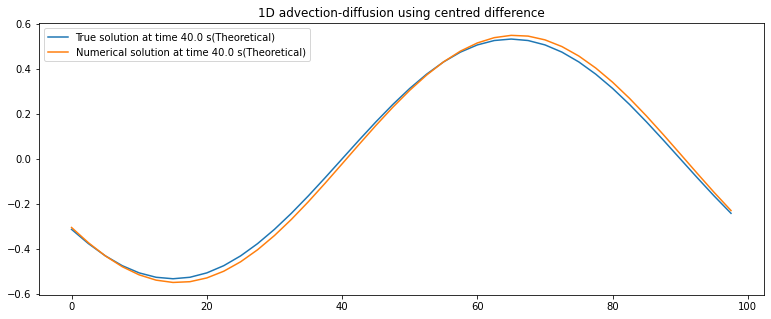

In [7]:
plt.figure(figsize = (13, 5))
plt.plot(x, phi_true, label = 'True solution at time ' + str(t) + ' s(Theoretical)')
plt.plot(x, phi_new, label = 'Numerical solution at time ' + str(t) + ' s(Theoretical)')
plt.legend()
plt.title('1D advection-diffusion using centred difference')

We see that when we have both advection and diffusion, the centred difference scheme works too, which is contrary to what Von-Neumann analysis predicted. This happens because we have an additional term - diffusion, and a part of this diffusion acts to dampen the numerical oscillations (which cause instability) induced by the centred difference method. This is great, because now, we have a second order accurate method, which is stable, as long as the Courant number stays less than 1.

## Error Analysis

We move on to the error analysis, again increasing the number of points in the domain and checking whether the error is reducing as we predict. Since we are using a central difference scheme, the error should reduce as $\frac{1}{nx^2}$, where $nx$ is the number of points in the domain.

In [8]:
#Length of domain
Lx = 100

#Set of points for which to perform error analysis
nx = [8,16,32,64,128,256,512,1024,2048]

#Some parameters and constants in the equation
g = 9.81
rho0 = 1025
kappa = 1.0
a = 1
error_diff = np.zeros(len(nx))

switch_adv_scheme = 0
#Iterating over all set of points
for i,nxi in enumerate(nx):
    #Spacing between points
    dx = Lx/nxi
    
    #Initialising values for each set of points
    x = np.linspace(0,Lx,nxi+1,dtype = float)
    x = x[0:-1]
    phi_old = (np.sin(lmda*x))
    phi_old_t0 = (np.sin(lmda*x))
    
    #Time parameters
    t_start = 0
    t_end = 40
    dt = 0.1/nxi
    
    for t in np.arange(t_start,t_end,dt):
        phi_new = phi_old + dt*elr.diff_x(kappa,phi_old,dx,nxi,switch_diff_scheme) - dt*elr.adv_x(
            a,phi_old,dx,nxi,switch_adv_scheme)
        phi_old = phi_new
    
    BC = np.exp(-lmda**2 * t * kappa) * np.sin(lmda*(x-a*t))
    
    error_iter = max(abs(BC - phi_new))
    error_diff[i] = error_iter

In [9]:
# Some reference variables to check the order of our scheme

#1/h (h is the grid spacing)
nx_inv = np.zeros(len(nx))

#1/h^2 (h is the grid spacing)
nx2_inv = np.zeros(len(nx))

for i,nxi in enumerate(nx):
    nx_inv[i] = 1/nxi
    nx2_inv[i] = 1/nxi**2

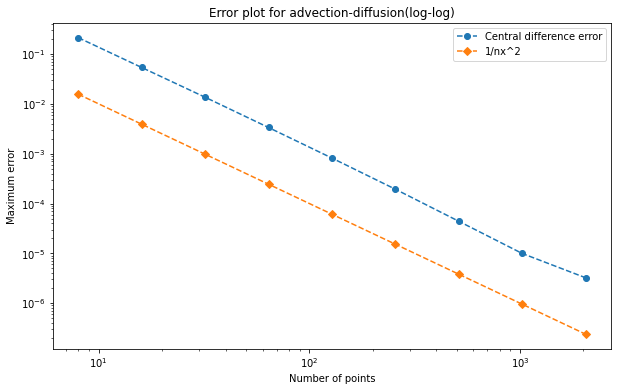

In [10]:
#Plotting

plt.figure(figsize = (10,6))
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Number of points")
plt.ylabel("Maximum error")
plt.plot(nx,error_diff,marker='o',linestyle = '--',label = 'Central difference error')
plt.plot(nx,nx2_inv,marker = 'D',linestyle = '--', label = '1/nx^2')
plt.title("Error plot for advection-diffusion(log-log)")
plt.legend()
plt.show()

As shown in the above figure, the error for the central difference scheme reduces as $\frac{1}{nx^2}$. A point worth mentioning is that the last point, $nx = 2048$ doesn't exactly follow the $\frac{1}{nx^2}$ graph (as shown in the figure). This occurs because as the number of points increases, $dx$ reduces, and to keep the Courant number ($ = a \frac{\Delta t}{\Delta x}$ less than 1, we need to make $dt$ sufficiently small. This anomaly arises because for $nx = 2048$, the $dt$ wasn't as small, and if the simulation was to run for a longer duration, instabilities would arise.